In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with_cache_data = {
    'total_calls': 10991,
    'total_time': 4275.683860,
    'avg_time_per_call': 0.389017,
    'steps': {
        'kv_cache_preparation': 0.357799,
        'embedding': 0.002926,
        'preprocessing': 0.007179,
        'hstu_inference': 0.010812,
        'postprocess_mlp_and_offload': 0.010192
    }
}

no_cache_data = {
    'total_calls': 10991,
    'total_time': 296.089506,
    'avg_time_per_call': 0.026939,
    'steps': {
        'embedding': 0.002914,
        'preprocessing': 0.008362,
        'hstu_inference': 0.013500,
        'postprocess_and_mlp': 0.002063
    }
}

In [ ]:
stages = ['embedding', 'preprocessing', 'hstu_inference', 'postprocess', 'kv_cache_preparation']
with_cache_times = [
    with_cache_data['steps']['embedding'],
    with_cache_data['steps']['preprocessing'],
    with_cache_data['steps']['hstu_inference'],
    with_cache_data['steps']['postprocess_mlp_and_offload'],  # 包含offload
    with_cache_data['steps']['kv_cache_preparation']
]

no_cache_times = [
    no_cache_data['steps']['embedding'],
    no_cache_data['steps']['preprocessing'],
    no_cache_data['steps']['hstu_inference'],
    no_cache_data['steps']['postprocess_and_mlp'],  # 不包含offload
    0  # 不带KV Cache没有这个阶段
]

<Figure size 1200x800 with 0 Axes>

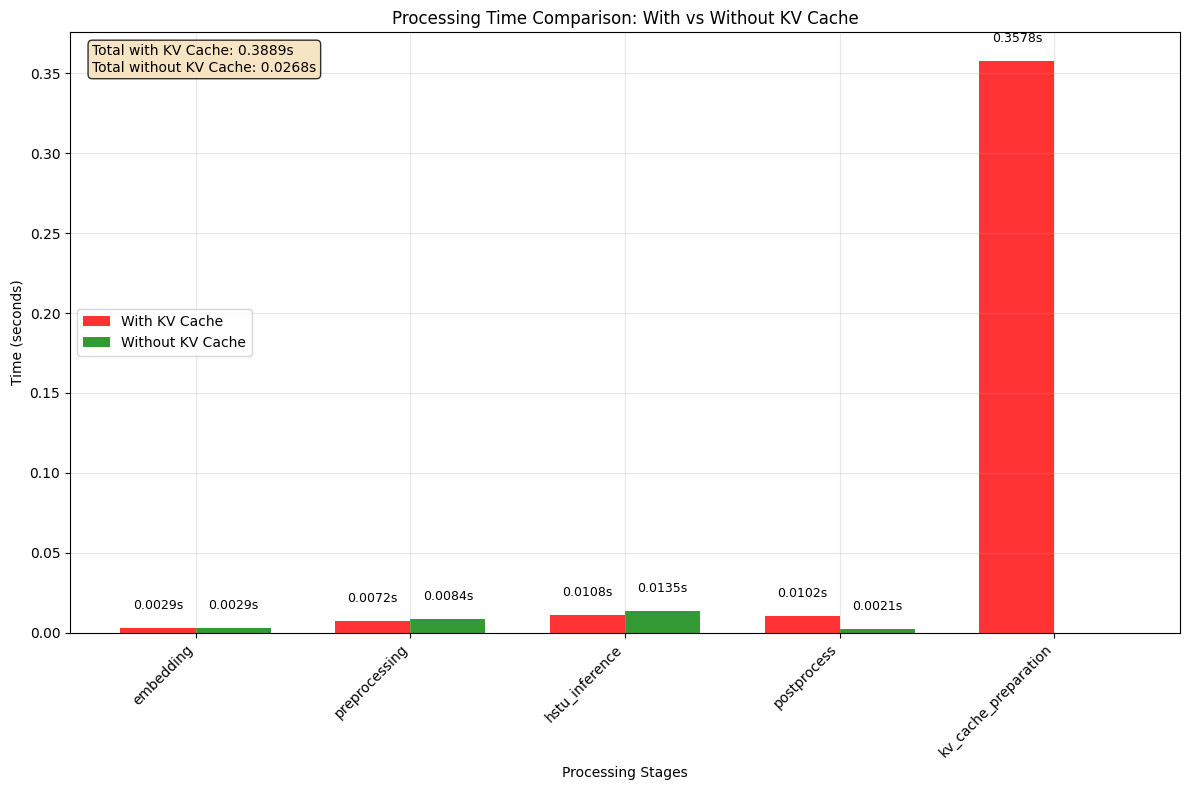

=== STAGE-BY-STAGE COMPARISON ===
Stage                     With KV Cache   Without KV Cache Ratio     
-----------------------------------------------------------------
embedding                 0.002926        0.002914        1.00x     
preprocessing             0.007179        0.008362        0.86x     
hstu_inference            0.010812        0.013500        0.80x     
postprocess               0.010192        0.002063        4.94x     
kv_cache_preparation      0.357799        0.000000        N/A       

Total                     0.388908        0.026839        14.49x

=== KEY FINDINGS ===
1. KV Cache preparation takes 0.357799s (92.0% of total time)
2. Without KV Cache is 14.49x faster overall
3. HSTU inference is actually faster with KV Cache: 0.010812s vs 0.013500s


In [5]:
plt.figure(figsize=(12, 8))

x = np.arange(len(stages))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(x - width/2, with_cache_times, width, label='With KV Cache', alpha=0.8, color='red')
bars2 = ax.bar(x + width/2, no_cache_times, width, label='Without KV Cache', alpha=0.8, color='green')

# 添加数值标签
for i, (bar, time_val) in enumerate(zip(bars1, with_cache_times)):
    if time_val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{time_val:.4f}s', ha='center', va='bottom', fontsize=9)

for i, (bar, time_val) in enumerate(zip(bars2, no_cache_times)):
    if time_val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{time_val:.4f}s', ha='center', va='bottom', fontsize=9)

# 设置图表属性
ax.set_xlabel('Processing Stages')
ax.set_ylabel('Time (seconds)')
ax.set_title('Processing Time Comparison: With vs Without KV Cache')
ax.set_xticks(x)
ax.set_xticklabels(stages, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# 添加总时间对比
total_with_cache = sum(with_cache_times)
total_without_cache = sum(no_cache_times)
ax.text(0.02, 0.98, f'Total with KV Cache: {total_with_cache:.4f}s\nTotal without KV Cache: {total_without_cache:.4f}s', 
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 打印详细分析
print("=== STAGE-BY-STAGE COMPARISON ===")
print(f"{'Stage':<25} {'With KV Cache':<15} {'Without KV Cache':<15} {'Ratio':<10}")
print("-" * 65)
for stage in stages:
    if stage == 'kv_cache_preparation':
        with_time = with_cache_data['steps'][stage]
        without_time = 0
        ratio = "N/A"
    elif stage == 'postprocess':
        with_time = with_cache_data['steps']['postprocess_mlp_and_offload']
        without_time = no_cache_data['steps']['postprocess_and_mlp']
        ratio = f"{with_time/without_time:.2f}x"
    else:
        with_time = with_cache_data['steps'][stage]
        without_time = no_cache_data['steps'][stage]
        ratio = f"{with_time/without_time:.2f}x"
    
    print(f"{stage:<25} {with_time:<15.6f} {without_time:<15.6f} {ratio:<10}")

print(f"\n{'Total':<25} {total_with_cache:<15.6f} {total_without_cache:<15.6f} {total_with_cache/total_without_cache:.2f}x")

# 关键发现
print(f"\n=== KEY FINDINGS ===")
print(f"1. KV Cache preparation takes {with_cache_data['steps']['kv_cache_preparation']:.6f}s ({(with_cache_data['steps']['kv_cache_preparation']/total_with_cache)*100:.1f}% of total time)")
print(f"2. Without KV Cache is {total_with_cache/total_without_cache:.2f}x faster overall")
print(f"3. HSTU inference is actually faster with KV Cache: {with_cache_data['steps']['hstu_inference']:.6f}s vs {no_cache_data['steps']['hstu_inference']:.6f}s")

<Figure size 1400x800 with 0 Axes>

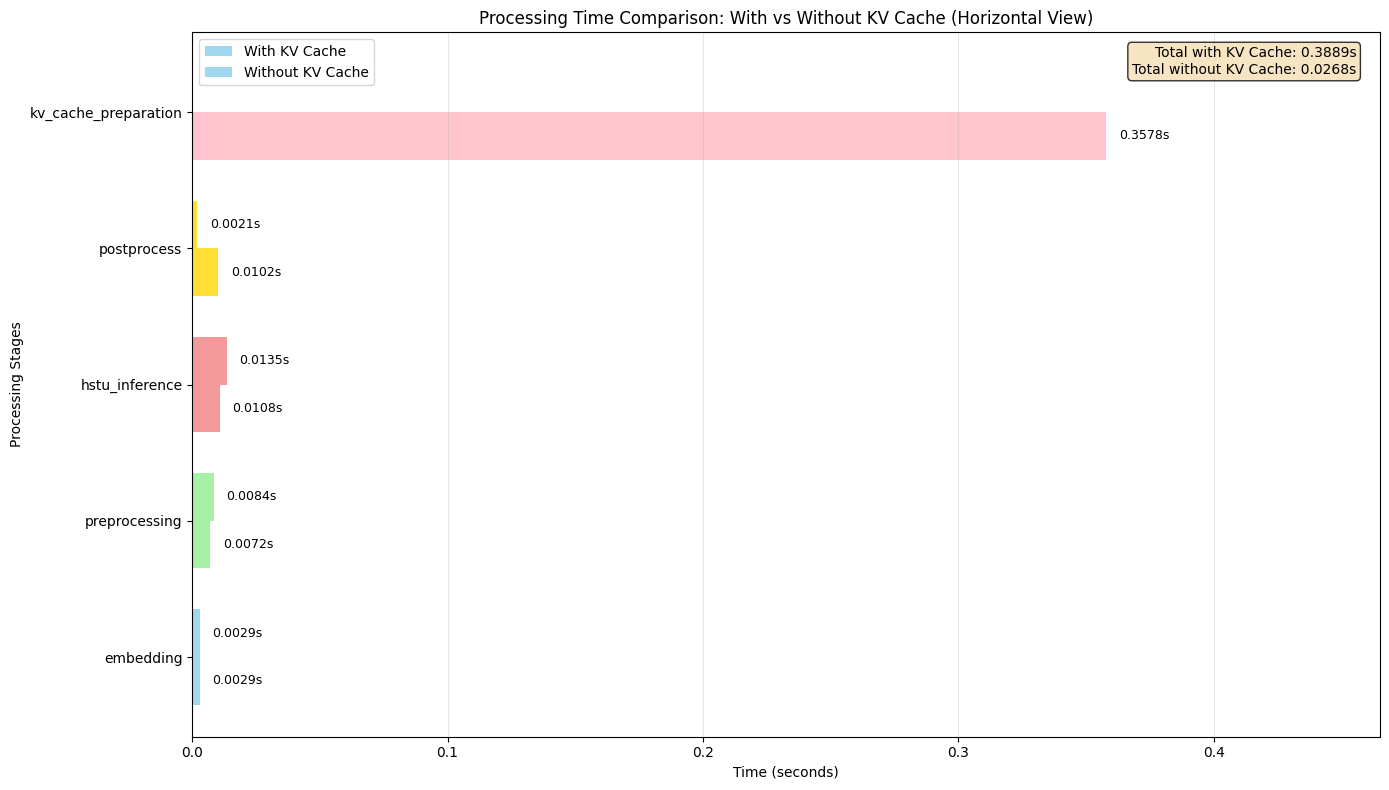

/tmp/ipykernel_153132/3198754774.py:140: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

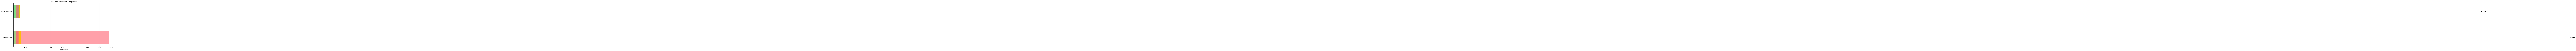

=== HORIZONTAL COMPARISON SUMMARY ===
Stage-wise comparison:
embedding            | 0.002926s | 0.002914s |   1.00x
preprocessing        | 0.007179s | 0.008362s |   0.86x
hstu_inference       | 0.010812s | 0.013500s |   0.80x
postprocess          | 0.010192s | 0.002063s |   4.94x
kv_cache_preparation | 0.357799s |        -   | Only in with-cache version

Total time comparison:
With KV Cache:    0.388908s
Without KV Cache: 0.026839s
Performance ratio: 14.49x slower with KV Cache


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 数据提取
with_cache_data = {
    'steps': {
        'kv_cache_preparation': 0.357799,
        'embedding': 0.002926,
        'preprocessing': 0.007179,
        'hstu_inference': 0.010812,
        'postprocess_mlp_and_offload': 0.010192
    }
}

no_cache_data = {
    'steps': {
        'embedding': 0.002914,
        'preprocessing': 0.008362,
        'hstu_inference': 0.013500,
        'postprocess_and_mlp': 0.002063
    }
}

# 重新组织数据 - 统一阶段名称
stages = ['embedding', 'preprocessing', 'hstu_inference', 'postprocess', 'kv_cache_preparation']

# 构建统一的数据结构
with_cache_times = []
no_cache_times = []

for stage in stages:
    if stage == 'postprocess':
        # 合并postprocess相关阶段
        with_cache_times.append(with_cache_data['steps']['postprocess_mlp_and_offload'])
        no_cache_times.append(no_cache_data['steps']['postprocess_and_mlp'])
    elif stage == 'kv_cache_preparation':
        # 只有with cache有这个阶段
        with_cache_times.append(with_cache_data['steps']['kv_cache_preparation'])
        no_cache_times.append(0)  # 不带cache的版本没有这个阶段，设为0
    else:
        # 其他共同阶段
        with_cache_times.append(with_cache_data['steps'][stage])
        no_cache_times.append(no_cache_data['steps'][stage])

# 创建横向分组柱状图
plt.figure(figsize=(14, 8))

# 设置y轴位置
y = np.arange(len(stages))
height = 0.35

# 创建横向柱状图
fig, ax = plt.subplots(figsize=(14, 8))

# 绘制横向柱状图
bars1 = ax.barh(y - height/2, with_cache_times, height, label='With KV Cache', 
                color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'], alpha=0.8)
bars2 = ax.barh(y + height/2, no_cache_times, height, label='Without KV Cache', 
                color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightgray'], alpha=0.8)

# 添加数值标签
for i, (bar, time_val) in enumerate(zip(bars1, with_cache_times)):
    if time_val > 0:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.4f}s', ha='left', va='center', fontsize=9)

for i, (bar, time_val) in enumerate(zip(bars2, no_cache_times)):
    if time_val > 0:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.4f}s', ha='left', va='center', fontsize=9)

# 设置图表属性
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Processing Stages')
ax.set_title('Processing Time Comparison: With vs Without KV Cache (Horizontal View)')
ax.set_yticks(y)
ax.set_yticklabels(stages)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 设置x轴范围以便更好地显示标签
max_time = max(max(with_cache_times), max(no_cache_times))
ax.set_xlim(0, max_time * 1.3)

# 添加总时间信息
total_with_cache = sum(with_cache_times)
total_without_cache = sum(no_cache_times)
ax.text(0.98, 0.98, f'Total with KV Cache: {total_with_cache:.4f}s\nTotal without KV Cache: {total_without_cache:.4f}s', 
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 创建另一种视图 - 堆叠横向柱状图
plt.figure(figsize=(14, 6))

fig, ax = plt.subplots(figsize=(14, 6))

y_pos = np.arange(2)
methods = ['With KV Cache', 'Without KV Cache']
total_times = [total_with_cache, total_without_cache]

# 绘制总时间对比
bars = ax.barh(y_pos, total_times, color=['red', 'green'], alpha=0.7, height=0.5)

# 添加数值标签
for i, (bar, time_val) in enumerate(zip(bars, total_times)):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
            f'{time_val:.2f}s', ha='left', va='center', fontsize=12, fontweight='bold')

# 在每个总时间条上添加阶段分解
# With KV Cache (位置在y=0)
left_pos = 0
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink']
for i, (stage, time_val) in enumerate(zip(stages, with_cache_times)):
    if time_val > 0:
        ax.barh(0, time_val, left=left_pos, height=0.5, color=colors[i], alpha=0.8)
        if time_val > 10:  # 只在较大的块上显示标签
            ax.text(left_pos + time_val/2, 0, f'{stage}\n{time_val:.1f}s', 
                   ha='center', va='center', fontsize=8)
        left_pos += time_val

# Without KV Cache (位置在y=1)
left_pos = 0
for i, (stage, time_val) in enumerate(zip(stages[:-1], no_cache_times[:-1])):  # 排除kv_cache_preparation
    if time_val > 0:
        ax.barh(1, time_val, left=left_pos, height=0.5, color=colors[i], alpha=0.8)
        if time_val > 0.5:  # 只在较大的块上显示标签
            ax.text(left_pos + time_val/2, 1, f'{stage}\n{time_val:.3f}s', 
                   ha='center', va='center', fontsize=8)
        left_pos += time_val

ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.set_xlabel('Time (seconds)')
ax.set_title('Total Time Breakdown Comparison')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# 打印关键统计
print("=== HORIZONTAL COMPARISON SUMMARY ===")
print(f"Stage-wise comparison:")
for stage, with_time, without_time in zip(stages, with_cache_times, no_cache_times):
    if stage == 'kv_cache_preparation':
        print(f"{stage:20} | {with_time:8.6f}s | {'-':>8}   | Only in with-cache version")
    else:
        ratio = with_time / without_time if without_time > 0 else float('inf')
        print(f"{stage:20} | {with_time:8.6f}s | {without_time:8.6f}s | {ratio:6.2f}x")

print(f"\nTotal time comparison:")
print(f"With KV Cache:    {total_with_cache:.6f}s")
print(f"Without KV Cache: {total_without_cache:.6f}s")
print(f"Performance ratio: {total_with_cache/total_without_cache:.2f}x slower with KV Cache")


<Figure size 1400x800 with 0 Axes>

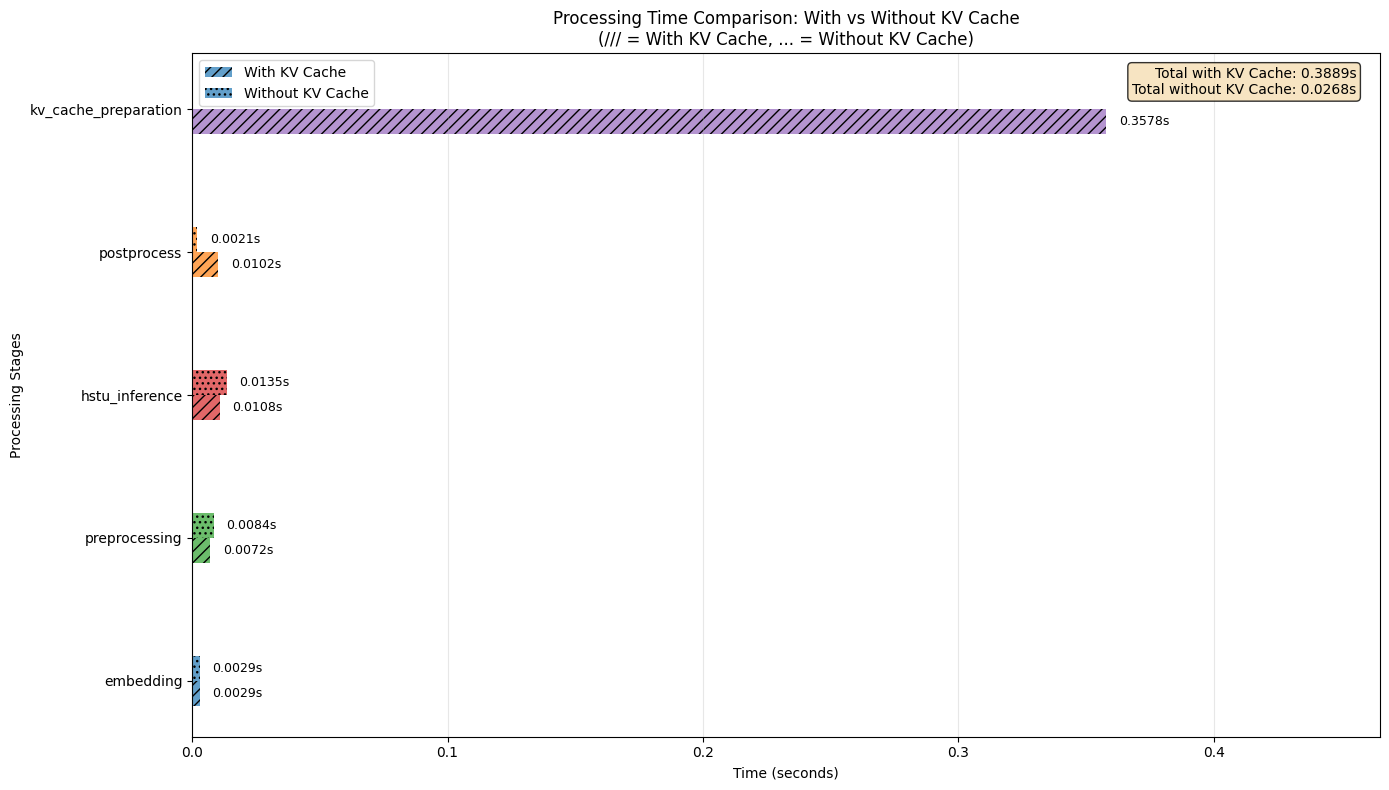

<Figure size 1400x800 with 0 Axes>

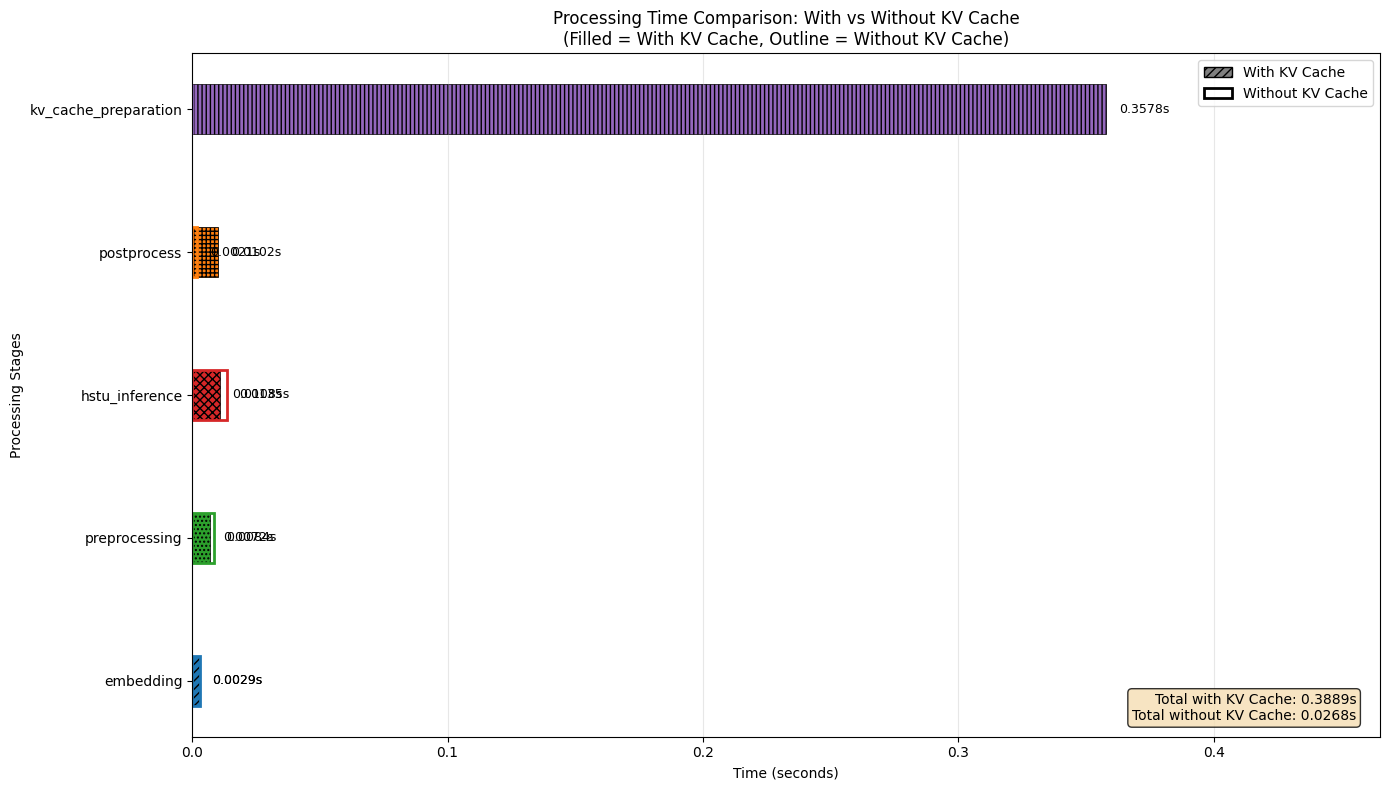

=== STAGE-WISE TIME COMPARISON ===
Stage                | With KV Cache | Without KV Cache | Ratio   
-----------------------------------------------------------------
embedding            | 0.002926     | 0.002914        | 1.00    x
preprocessing        | 0.007179     | 0.008362        | 0.86    x
hstu_inference       | 0.010812     | 0.013500        | 0.80    x
postprocess          | 0.010192     | 0.002063        | 4.94    x
kv_cache_preparation | 0.357799     | -               | N/A     

Total                | 0.388908     | 0.026839        | 14.49   x


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# 数据提取
with_cache_data = {
    'steps': {
        'kv_cache_preparation': 0.357799,
        'embedding': 0.002926,
        'preprocessing': 0.007179,
        'hstu_inference': 0.010812,
        'postprocess_mlp_and_offload': 0.010192
    }
}

no_cache_data = {
    'steps': {
        'embedding': 0.002914,
        'preprocessing': 0.008362,
        'hstu_inference': 0.013500,
        'postprocess_and_mlp': 0.002063
    }
}

# 重新组织数据 - 统一阶段名称
stages = ['embedding', 'preprocessing', 'hstu_inference', 'postprocess', 'kv_cache_preparation']

# 构建统一的数据结构
with_cache_times = []
no_cache_times = []

for stage in stages:
    if stage == 'postprocess':
        with_cache_times.append(with_cache_data['steps']['postprocess_mlp_and_offload'])
        no_cache_times.append(no_cache_data['steps']['postprocess_and_mlp'])
    elif stage == 'kv_cache_preparation':
        with_cache_times.append(with_cache_data['steps']['kv_cache_preparation'])
        no_cache_times.append(0)
    else:
        with_cache_times.append(with_cache_data['steps'][stage])
        no_cache_times.append(no_cache_data['steps'][stage])

# 创建横向条形图 - 用填充图案区分带不带KV Cache
plt.figure(figsize=(14, 8))

# 设置y轴位置
y = np.arange(len(stages))
height = 0.35

# 阶段颜色映射（统一颜色）
stage_colors = {
    'embedding': '#1f77b4',      # 蓝色
    'preprocessing': '#2ca02c',   # 绿色
    'hstu_inference': '#d62728',  # 红色
    'postprocess': '#ff7f0e',     # 橙色
    'kv_cache_preparation': '#9467bd'  # 紫色
}

fig, ax = plt.subplots(figsize=(14, 8))

# 绘制横向条形图
# 带KV Cache的条形图（使用斜线填充）
bars1 = ax.barh(y - height/4, with_cache_times, height/2, 
                color=[stage_colors[stage] for stage in stages],
                hatch='///', alpha=0.7, label='With KV Cache')

# 不带KV Cache的条形图（使用点状填充）
bars2 = ax.barh(y + height/4, no_cache_times, height/2, 
                color=[stage_colors[stage] for stage in stages],
                hatch='...', alpha=0.7, label='Without KV Cache')

# 添加数值标签
for i, (bar, time_val) in enumerate(zip(bars1, with_cache_times)):
    if time_val > 0:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.4f}s', ha='left', va='center', fontsize=9)

for i, (bar, time_val) in enumerate(zip(bars2, no_cache_times)):
    if time_val > 0:
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{time_val:.4f}s', ha='left', va='center', fontsize=9)

# 设置图表属性
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Processing Stages')
ax.set_title('Processing Time Comparison: With vs Without KV Cache\n(/// = With KV Cache, ... = Without KV Cache)')
ax.set_yticks(y)
ax.set_yticklabels(stages)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 设置x轴范围
max_time = max(max(with_cache_times), max(no_cache_times))
ax.set_xlim(0, max_time * 1.3)

# 添加总时间信息
total_with_cache = sum(with_cache_times)
total_without_cache = sum(no_cache_times)
ax.text(0.98, 0.98, f'Total with KV Cache: {total_with_cache:.4f}s\nTotal without KV Cache: {total_without_cache:.4f}s', 
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 创建另一种视图 - 使用不同填充图案
plt.figure(figsize=(14, 8))

fig, ax = plt.subplots(figsize=(14, 8))

# 使用不同的填充图案
hatches = ['////', '....', 'xxxx', '++++', '||||']  # 带KV Cache
hatches_no = ['////', '....', 'xxxx', '++++', '    ']  # 不带KV Cache（空格表示无填充）

# 绘制条形图
bars1 = ax.barh(y, with_cache_times, height, 
                color=[stage_colors[stage] for stage in stages],
                edgecolor='black', linewidth=0.5)

bars2 = ax.barh(y, no_cache_times, height, 
                color='none',  # 透明填充
                edgecolor=[stage_colors[stage] for stage in stages], 
                linewidth=2, linestyle='-')

# 为带KV Cache的条形图添加填充
for bar, hatch in zip(bars1, hatches):
    bar.set_hatch(hatch)

# 添加数值标签
for i, (with_time, without_time) in enumerate(zip(with_cache_times, no_cache_times)):
    if with_time > 0:
        ax.text(with_time + 0.005, i, f'{with_time:.4f}s', 
                ha='left', va='center', fontsize=9)
    if without_time > 0:
        ax.text(without_time + 0.005, i, f'{without_time:.4f}s', 
                ha='left', va='center', fontsize=9)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Processing Stages')
ax.set_title('Processing Time Comparison: With vs Without KV Cache\n(Filled = With KV Cache, Outline = Without KV Cache)')
ax.set_yticks(y)
ax.set_yticklabels(stages)
ax.grid(True, alpha=0.3, axis='x')

# 创建图例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', hatch='////', label='With KV Cache', edgecolor='black'),
    Patch(facecolor='none', edgecolor='black', linewidth=2, label='Without KV Cache')
]
ax.legend(handles=legend_elements)

# 设置x轴范围
ax.set_xlim(0, max_time * 1.3)

# 添加总时间信息
ax.text(0.98, 0.02, f'Total with KV Cache: {total_with_cache:.4f}s\nTotal without KV Cache: {total_without_cache:.4f}s', 
        transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 打印关键统计
print("=== STAGE-WISE TIME COMPARISON ===")
print(f"{'Stage':<20} | {'With KV Cache':<12} | {'Without KV Cache':<15} | {'Ratio':<8}")
print("-" * 65)
for stage, with_time, without_time in zip(stages, with_cache_times, no_cache_times):
    if stage == 'kv_cache_preparation':
        print(f"{stage:<20} | {with_time:<12.6f} | {'-':<15} | {'N/A':<8}")
    else:
        ratio = with_time / without_time if without_time > 0 else float('inf')
        print(f"{stage:<20} | {with_time:<12.6f} | {without_time:<15.6f} | {ratio:<8.2f}x")

print(f"\n{'Total':<20} | {total_with_cache:<12.6f} | {total_without_cache:<15.6f} | {total_with_cache/total_without_cache:<8.2f}x")
